In [1]:
import pandas as pd
import numpy 
import os
import git
import pickle
import matplotlib.pyplot as plt
pd.set_option('display.max_colwidth', -1)
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
import warnings
warnings.filterwarnings('ignore')
from matplotlib import pyplot
import numpy as np
import re
from collections import Counter
# import gensim
# from gensim import corpora
import os
import networkx as nx
import ast

/home/drew_william2345/anaconda3/envs/multimodal-env/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.utils import shuffle

In [3]:
from keras.preprocessing.sequence import pad_sequences
from keras.optimizers import SGD
from keras.models import Model, Input
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Embedding
from keras.layers import Bidirectional
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.layers import Reshape
from keras.layers import Average
from keras.layers import Dropout
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [4]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from tqdm.auto import tqdm

In [5]:
## Read the labelled files and the poly_user
def get_git_root(path):
	git_repo = git.Repo(path, search_parent_directories=True)
	git_root = git_repo.git.rev_parse("--show-toplevel")
	return git_root

In [6]:
from nltk.corpus import wordnet as wn
def get_lemma(word):
    lemma = wn.morphy(word)
    if lemma is None:
        return word
    else:
        return lemma

In [7]:
# setup env
import nltk
from nltk.corpus import stopwords
nltk.download('wordnet')
nltk.download('stopwords')
stopwords = set(stopwords.words('english'))

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/drew_william2345/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/drew_william2345/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [8]:
## tokenize the text..
from keras.preprocessing.text import Tokenizer
from keras.layers import Embedding
from nltk.tokenize import TweetTokenizer
tweet_tknzr = TweetTokenizer()
def get_tokens(sentence):
#     tokens = nltk.word_tokenize(sentence)  # now using tweet tokenizer
    tokens = tweet_tknzr.tokenize(sentence)
    tokens = [token for token in tokens if (token not in stopwords and len(token) > 1)]
    tokens = [get_lemma(token) for token in tokens]
    return (tokens)

In [9]:
def clean_text(text):
    text = re.sub(r'(https?://\S+)', "", text) ## remove url
    text = re.sub(r'(\@\w+)', "author",text)   ## remove @ mentions with author
    text = re.sub(r'(@)', "",text)             ## remove @ symbols
    text = re.sub(r'(author)',"",text)         ## remove author
    text = re.sub(r'(#)', "",text)             ## removing the hashtags signal 
    text = re.sub(r'(RT )', "",text)         ## remove the retweet info as they dont convey any information
    text.rstrip 
    text.lstrip
    return(text)

In [10]:
# create the word2vec dict from the dictionary
def get_word2vec(file_path):
    file = open(file_path, "r")
    if (file):
        word2vec = dict()
#         split = file.read().splitlines()
        for line in file:
            split_line = line.split(' ')
            key = split_line[0] # the first word is the key
            value = np.array([float(val) for val in split_line[1:]])
            word2vec[key] = value
        return (word2vec)
    else:
        print("invalid fiel path")

In [11]:
## calculate the mean of the embeddings
class MeanEmbeddingVectorizer(object):
	def __init__(self, word2vec):
		self.word2vec = word2vec
		# if a text is empty we should return a vector of zeros
		# with the same dimensionality as all the other vectors
		self.dim = len(next(iter(word2vec.values())))

	def fit(self, X, y):
		return self

	def transform(self, X):
		return np.array([
			np.mean([self.word2vec[w] for w in words if w in self.word2vec]
					or [np.zeros(self.dim)], axis=0)
			for words in tqdm(X)
		])

In [ ]:
## get the embedding matrix weights:
from numpy import zeros
from keras.preprocessing.text import Tokenizer
def get_embedding_matrix(keras_tkzr,word2vec):
    vocab_size = len(keras_tkzr.word_index) + 1
    embedding_matrix = zeros((vocab_size, 100))
    for word, i in keras_tkzr.word_index.items():
        embedding_vector = word2vec.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
    return (embedding_matrix,vocab_size)

In [ ]:
## pass to the bi-lstm model
def create_model(max_len,vocab_size,embedding_matrix):
    input = Input(shape=(max_len,))
    model = Embedding(vocab_size,100,weights=[embedding_matrix],input_length=max_len)(input)
    model =  Bidirectional (LSTM (100,return_sequences=True,dropout=0.50),merge_mode='concat')(model)
    model = TimeDistributed(Dense(100,activation='relu'))(model)
    model = Flatten()(model)
    model = Dense(100,activation='relu')(model)
    output = Dense(3,activation='softmax')(model)
    model = Model(input,output)
    model.compile(loss='sparse_categorical_crossentropy',optimizer='adam', metrics=['accuracy'])
    return model

In [ ]:
from keras.preprocessing.text import Tokenizer
def load_data(df,max_len):
    keras_tkzr = Tokenizer()
    le = LabelEncoder()
    keras_tkzr.fit_on_texts(df["tweetText"])
    ## getting input X
    token_list = list(df['tweetText'].apply(get_tokens))
    encoded_docs = keras_tkzr.texts_to_sequences(token_list)
    max_len = max_len
    X = pad_sequences(encoded_docs, maxlen=max_len, padding='post')
    ## getting output Y
    Y = (list(df['label']))
    le.fit(Y)
    le.classes_
    y = le.transform(Y)
    return (X,y,keras_tkzr)

In [ ]:
## get the trained model
def train_evaluate_model(model,X_train,Y_train,X_test,Y_test):
    loss, accuracy = model.evaluate(X_test, Y_test, verbose=2)
    print('Accuracy: %f' % (accuracy*100))
    Y_pred = model.predict(X_test)
    y_pred = np.array([np.argmax(pred) for pred in Y_pred])
    # scores = cross_val_score(model, X_test, Y_test, cv=5)
    print('  Classification Report:\n',classification_report(Y_test,y_pred),'\n')
    precision,recall,fscore,_ = precision_recall_fscore_support(Y_test,y_pred)
    return (model,precision,recall,fscore)

In [ ]:
def fit_model(model,X_train,Y_train,epoch):
    hist = model.fit(X_train,Y_train,validation_split=0.25, nb_epoch = epoch, verbose = 2)
    return model,hist

In [12]:
top_dir = os.path.join(get_git_root(os.getcwd()))
input_dir = os.path.join(get_git_root(os.getcwd()),"input")
embeddings_dir  = os.path.join(get_git_root(os.getcwd()),"input","embeddings")
annotatted_dir = os.path.join(input_dir,"annotated_data")
classifier_dir = os.path.join(get_git_root(os.getcwd()),"models","classifier")
model_dir = os.path.join(get_git_root(os.getcwd()),"models")
poly_dir = os.path.join(model_dir,"poly_users")

In [13]:
glove_embeddings = os.path.join(embeddings_dir,"glove.twitter.27B.100d.txt")

In [14]:
# df_following_final = pd.read_csv(os.path.join(input_dir,"following_final.csv"))

In [17]:
df_dataset = pd.read_csv(os.path.join(input_dir,"dataset.csv"),lineterminator="\n")

In [18]:
print(len(df_dataset))   # 11,578,887
print(len(df_dataset.userID.unique())) # 551,261

11578887
551261


In [19]:
df_dataset.head(5)

,userID,tweetId,tweetCreatedAt,tweetText
0,112655608,550592152947150848,2015-01-01 09:59:33,ON AIR : Rasmus Juul &amp; Kasual - Got No Rhythm (Mark Lower Remix) - (http://t.co/w9HX9OSoND)
1,405051688,550774424358887424,2015-01-01 22:03:50,Listen to Zella Day - Seven Nation Army ϟ Kasúal &amp; Rasmus Juul Edit by Kasúal #np on #SoundCloud ❤️ https://t.co/zIY3KNP1Cb
2,1442149842,550796793936896000,2015-01-01 23:32:43,@halahoran so proud of you juul i love you lots
3,1615154773,551081300049006592,2015-01-02 18:23:15,"@vitaminiam that's so good, i have that with juul hahaha (she's from nuenen)"
4,13163002,551127239321206785,2015-01-02 21:25:47,"""We should care enough about winning to put in sufficient effort, but we should see learning rather than winning the ultimate goal"" J. Juul"


## predicting promoter, regular, news from data using bilstm model -- finally use svm

### loading the svm vectorizer trained on annottaion data

In [35]:
# len(df_annotation)
# ## 0 -news
# ## 1 - promo
# ## 2 -regular users
# print(df_annotation.label.value_counts())
# df_annotation = df_annotation.sample(frac=1)
# df_annotation = df_annotation.reset_index()
# ## take a balnced sample of 200 from each category
# df_news = (df_annotation[df_annotation.label == 0])[:200] 
# df_reg = (df_annotation[df_annotation.label == 2])[:200] 
# df_promo = (df_annotation[df_annotation.label == 1])[:200] 
# df_annotation = pd.concat([df_news,df_promo,df_reg])
# ## random sample annotation file
# df_annotation = df_annotation.sample(frac=1).reset_index(drop=True)

# ## tokenize the sentences
# df_annotation['tweetText'] = df_annotation['tweetText'].apply(clean_text)
# df_annotation.loc[df_annotation.label.isin([1,2])].head(200)

# ## looking at the tokenized data
# df_test = pd.DataFrame()
# df_test["tweetText"] = list(df_annotation['tweetText'].apply(get_tokens))
# df_test['label'] = list(df_annotation["label"])
# df_test

## getting mean , quantile length of text
# df_len = list()
# for tokens in token_list:
#     df_len.append(len(tokens))
# df_len = pd.DataFrame(df_len)
# df_len.boxplot()
# df_len.describe()
# max_len = int(df_len.quantile(0.95))  ## take the max_len = 90 percentile
# max_len = 27

## we use svm for annotation

In [36]:
len(df_dataset)

11578887

In [38]:
## load the model and tokenizer
svm_tf = pickle.load(open(os.path.join(classifier_dir,"annotation_classifier","svm_tf.pkl"),"rb"))
tfidf_vect = pickle.load(open(os.path.join(classifier_dir,"annotation_classifier","tf_idf_vect.pkl"),"rb"))

In [39]:
data = df_dataset["tweetText"]
X = tfidf_vect.transform(data)

In [40]:
y = svm_tf.predict(X) 

In [42]:
print(X.shape)
print(y.shape)

(11578887, 3789)
(11578887,)


In [44]:
df_dataset["label"] = y

In [51]:
## regualr tweets
use= len(df_dataset.loc[df_dataset.label == 2])
print(use/len(df_dataset))
print(use)

0.4901646419038376
5675561


In [48]:
## news tweets
news = len(df_dataset.loc[df_dataset.label == 0])
print(news/ len(df_dataset))

0.38150722085810146


In [49]:
## promotional tweets
prom = len(df_dataset.loc[df_dataset.label == 1])
print(prom/ len(df_dataset))

0.12832813723806097


## predicting regular, promoters and news users

In [50]:
temp = pd.get_dummies(df_dataset,columns=["label"],prefix=['cat'])
users_type = temp.groupby(by="userID").agg({'cat_0': 'sum','cat_1':'sum','cat_2':'sum'})
users_type = users_type.reset_index()
users_type["label"] = users_type[['cat_0','cat_1','cat_2']].idxmax(axis=1)
## sanity check
# regular tweets 5675561
(np.sum(list(users_type["cat_2"])))

5675561.0

### plot of user, promoter and news..

total users 551261
regular_users 432316
promoters users 31578
news users, 87367
551261
551261


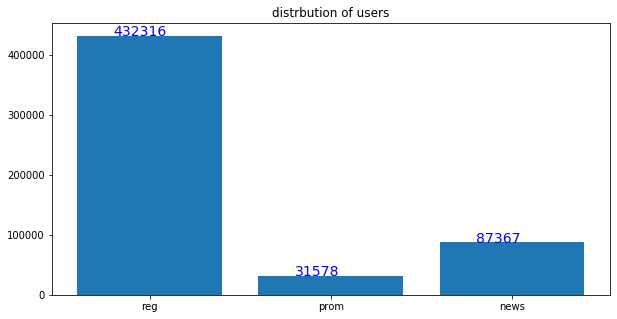

In [53]:
## no of users in each category
print("total users",len(users_type))
print("regular_users",len(users_type.loc[users_type.label == "cat_2"]))
print("promoters users",len(users_type.loc[users_type.label == "cat_1"]))
print("news users,",len(users_type.loc[users_type.label == "cat_0"]))
users_ = {"reg":len(users_type.loc[users_type.label == "cat_2"]),
 "prom":len(users_type.loc[users_type.label == "cat_1"]),
 "news":len(users_type.loc[users_type.label == "cat_0"])}

## sanity check
print(np.sum(list(users_.values())))
print(len(users_type.userID.unique()))

## plotting each user by category
fig, ax = plt.subplots(figsize=(10,5)) 
ax.set_title("distrbution of users")
ax.bar(users_.keys(),users_.values())
for idx,(key,value) in enumerate(users_.items()):
    ax.text( idx - 0.2 ,value + 0.5, value, color='blue',fontsize=14)

### getting the normal users

In [74]:
## getting all the tweets from normal users(who have max number of user expressed tweets)
regular_users = list(users_type["userID"].loc[users_type.label == "cat_2"])
normal_tweets = (df_dataset.loc[df_dataset.userID.isin(regular_users)])

In [56]:
users_type.to_csv(os.path.join(input_dir,"labelled_data","users_type.csv"))

In [58]:
df_dataset.to_csv(os.path.join(input_dir,"labelled_data","dataset.csv"))

In [62]:
len(regular_users)

432316

In [63]:
len(normal_tweets)

6512011

## predicting poly and mono users.. (check with most common words as well)

In [64]:
def build_vocab(tokens_list):
    vocab = Counter()
    for tokens in tokens_list:
        vocab.update(tokens)
    return vocab

In [65]:
# return clean text
def prepare_text_LDA(sentence):
#     tokens = nltk.word_tokenize(sentence)  # now using tweet tokenizer
    tweet_tknzr = TweetTokenizer()
    tokens = tweet_tknzr.tokenize(sentence)
    tokens = [token.lower() for token in tokens if (token not in stopwords and token.isalpha())] # stopwords removal
    tokens = [get_lemma(token) for token in tokens]  # lemmatization
    return (" ".join(tokens))

In [66]:
## join al the of the tweets for each user
def get_tweets_user(df):
    df_tweets_comb = list()
    users = df.userID.unique()
    for user in users:
        tweets =(df.loc[df.userID == user])
        tweets_f = (" . ".join(tweets["tweetText"]))
        df_tweets_comb.append((user,tweets_f))
    df_user = pd.DataFrame(df_tweets_comb, columns=["userID","tweetText"])
    return (df_user)

In [102]:
## getting the weed and juul pattern
print("extracting the pattern for weeds")
weed_words = pickle.load(open(os.path.join(model_dir, "weed_words.pkl"), "rb"))
# weed_words.remove('grass')
# weed_words.remove('pot')
# weed_words.remove('smoke')
# weed_words.remove('bud')
# weed_words.remove('joint')
#  weed_words.remove('CBD oil')
# weed_words = [(" " + word + " ") for word in weed_words]
pattern_weed = "|".join(weed_words)
print("extracting the pattern for juul")
pattern_juul = 'juul'

extracting the pattern for weeds
extracting the pattern for juul


In [103]:
pattern_weed

'weed|ganja|marijuana|cannabis|mary jane|hemp|marihuana|hash|reefer|hashish|herb|bhang|green goddess|locoweed|maryjane|spliff|wacky baccy|sinsemilla|doobie|acapulco gold|CBD|THC'

In [78]:
## preprocesing the tweets
tqdm.pandas()
normal_tweets["tweetText"] = normal_tweets["tweetText"].progress_apply(clean_text)
# normal_tweets["tweetText"] = (normal_tweets["tweetText"].progress_apply(prepare_text_LDA))



 48%|████▊     | 3147771/6512011 [00:42<00:24, 137852.47it/s]

In [83]:
## load the weed tweets
weed_tweets = normal_tweets[normal_tweets['tweetText'].str.contains(pattern_weed, case=False)]
print("weed tweets = ",len(weed_tweets))
poly_users = list(weed_tweets.userID.unique())
print("no of poly users = ", len(poly_users))

weed tweets =  5500891
no of poly users =  431942


In [84]:
normal_users = list(normal_tweets.userID.unique())
poly_length = len(poly_users)
total_users_length = len(normal_users)
mono_length = total_users_length - poly_length
print("total users = ", total_users_length)
print("no of poly users = ", poly_length)
print("no of mono users = ", mono_length)
print("% of poly users is ", poly_length / total_users_length)
print("% of mono users is ", mono_length / total_users_length)

total users =  432316
no of poly users =  431942
no of mono users =  374
% of poly users is  0.9991348920696898
% of mono users is  0.000865107930310236


## dump the users

In [87]:
import pickle
def dump_obj(obj,pathname):
    with open(pathname,"wb") as f:
        pickle.dump(obj,f)

In [89]:
# dump the poly_users,regualar_users
poly_dir = os.path.join(model_dir,"poly_users")
pathname = os.path.join(poly_dir,"poly_users.pkl")
dump_obj(poly_users,pathname)
pathname = os.path.join(poly_dir,"normal_users.pkl")
dump_obj(regular_users,pathname)

## get the most common words

### load the poly - mono users

In [ ]:
poly_users = pickle.load(open(os.path.join(poly_dir,"poly_users.pkl"),"rb"))
normal_users = pickle.load(open(os.path.join(poly_dir,"normal_users.pkl"),"rb"))
df_dataset = pd.read_csv(os.path.join(input_dir,"labelled_data","tweets_predicted.csv"),lineterminator="\n")

In [95]:
# normal_tweets = df_dataset.loc[df_dataset.userID.isin(normal_users)]
poly_tweets = df_dataset.loc[df_dataset.userID.isin(poly_users)]
mono_users = list(set(normal_users) - set(poly_users))
mono_tweets = df_dataset.loc[df_dataset.userID.isin(mono_users)]

### with rt

In [104]:
print("all tweets by poly users: ", len(poly_tweets))
print("poly users (based with retweets):", len(poly_tweets.userID.unique()))

all tweets by poly users:  6510725
poly users (based with retweets): 431942


In [105]:
print("all tweets by mono users: ", len(mono_tweets))
print("mono users (based with retweets):", len(mono_tweets.userID.unique()))

all tweets by mono users:  1286
mono users (based with retweets): 374


In [ ]:
## cleaning the text
poly_tweets["tweetText"] = poly_tweets["tweetText"].apply(clean_text)
mono_tweets["tweetText"] = mono_tweets["tweetText"].apply(clean_text)
## tokenizing and lemmatizing
poly_tweets["tweetText"] = (poly_tweets["tweetText"].apply(prepare_text_LDA))
mono_tweets["tweetText"] = mono_tweets["tweetText"].apply(prepare_text_LDA)

### getting most coomon words for each user

In [ ]:
poly_tweets_user = get_tweets_user(poly_tweets)
mono_tweets_user = get_tweets_user(mono_tweets)

In [ ]:
tokens_p = list(poly_tweets_user["tweetText"].apply(get_tokens))
tokens_j = list(mono_tweets_user["tweetText"].apply(get_tokens))

In [ ]:
vocab = build_vocab(tokens_p)
vocab.most_common()[:30]

In [ ]:
## most common words for juul user tweets
vocab1 = build_vocab(tokens_j)
vocab1.most_common()[:30]

## LDA

In [ ]:
temp_dir = os.path.join(model_dir,"temp")

In [ ]:
dictionary = corpora.Dictionary(tokens_p)  # tokens_j
corpus = [dictionary.doc2bow(text) for text in tokens_p] # tokens_j
pickle.dump(corpus, open(os.path.join(temp_dir,'corpus_m.pkl'), 'wb'))
dictionary.save(os.path.join(temp_dir,'dictionary_m.gensim'))
## LDA
NUM_TOPICS = 5
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = NUM_TOPICS, id2word=dictionary, passes=8)
ldamodel.save(os.path.join(temp_dir,'model_m.gensim'))
topics = ldamodel.print_topics(num_words=4)

In [ ]:
for topic in topics:
    print(topic)

In [ ]:
## poly
dictionary = gensim.corpora.Dictionary.load(os.path.join(temp_dir,'dictionary_m.gensim'))
corpus = pickle.load(open(os.path.join(temp_dir,'corpus_m.pkl'), 'rb'))
lda = gensim.models.ldamodel.LdaModel.load(os.path.join(temp_dir,'model_m.gensim'))
lda_display = pyLDAvis.gensim.prepare(lda, corpus, dictionary, sort_topics=False)
pyLDAvis.display(lda_display)

In [ ]:
##### mono
dictionary = corpora.Dictionary(tokens_j)  # tokens_j
corpus = [dictionary.doc2bow(text) for text in tokens_j] # tokens_j
pickle.dump(corpus, open(os.path.join(temp_dir,'corpus_m.pkl'), 'wb'))
dictionary.save(os.path.join(temp_dir,'dictionary_m.gensim'))
## LDA
NUM_TOPICS = 5
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = NUM_TOPICS, id2word=dictionary, passes=8)
ldamodel.save(os.path.join(temp_dir,'model_m.gensim'))
topics = ldamodel.print_topics(num_words=4)

In [ ]:
## mono
dictionary = gensim.corpora.Dictionary.load(os.path.join(temp_dir,'dictionary_m.gensim'))
corpus = pickle.load(open(os.path.join(temp_dir,'corpus_m.pkl'), 'rb'))
lda = gensim.models.ldamodel.LdaModel.load(os.path.join(temp_dir,'model_m.gensim'))
lda_display = pyLDAvis.gensim.prepare(lda, corpus, dictionary, sort_topics=False)
pyLDAvis.display(lda_display)

## training_classifier to predict poly vs mono user -- no longer valid

## get further categorization of poly_subtypes

In [106]:
## @return the posotion of juul timeline in the list of weeds
def get_postion(times_j, list_w):
    if list_w is not None:
        pos = -1
        for idx,ele in enumerate(list_w):
            if (times_j) > ele:
                continue
            else:
                pos = idx
                break
        if pos == -1:
            pos = len(list_w)
        return pos

In [108]:
len(df_dataset.userID.unique())

551261

In [ ]:
# get weed first and juul first for each of the poly users

In [110]:
print("*** starting with the poly sub type users")
juul_before = list()
juul_after = list()
# poly_middle = list()
_und = list()
total_users = list(df_dataset.userID.unique())
for user in tqdm(poly_users):
    user_tweets = df_dataset.loc[df_dataset.userID == user]
    user_tweets = user_tweets.sort_values(by='tweetCreatedAt', ascending=True)  # sort by tweet created at
    times_j = None
    list_w = None
    j_anchor = list(user_tweets['tweetCreatedAt'].loc[user_tweets['tweetText'].str.contains(pattern_juul, case=False)]) ## get the first occurance
    if j_anchor:
        time_j = pd.to_datetime(j_anchor[0])
    else:
        time_j = None
    weed_tweets = user_tweets[user_tweets['tweetText'].str.contains(pattern_weed, case=False)]
    if (len(weed_tweets) > 0):
        if (len(weed_tweets) > 0):
            list_w = pd.to_datetime(list(weed_tweets[
                                              'tweetCreatedAt']))
    else:
        list_w = None
    if (time_j is not None and list_w is not None):
        pos = get_postion(time_j,list_w)              ## @TODO change..create function
        if (pos == 0):
            juul_before.append(user)
        else:
            juul_after.append(user)
    else:
        _und.append(user)                         ## if we can't determine the juul tweets in the user..
print("Poly type users calculated")
print("total poly users =", len(poly_users))
print("****************\n")
print("% of juul before users = ", len(juul_before) / len(poly_users))
print("len of juul before = ",len(juul_before))
print("\n")
print("% of juul after users = ", len(juul_after) / len(poly_users))
print("len of juul after = ",len(juul_after))
print("\n")
print("len of undefined users = ", len(_und) )

*** starting with the poly sub type users


KeyboardInterrupt: 

Poly type users calculated
total users = 640

****************

% of juul before users =  0.190625
len of juul before =  122


% of juul after users =  0.809375
len of juul after =  518


% of undefined users =  0.0

## plotting the change of poly_before to poly again

In [ ]:
## getting the poly_before user juul before and first weed tweet

In [ ]:
len(juul_before)

In [ ]:
juul_before_tweets = df_final.loc[df_final.userID.isin(juul_before)]

In [ ]:
len(juul_before_tweets)

In [ ]:
juul_tweets = juul_before_tweets.loc[juul_before_tweets["tweetText"].str.contains(pattern_juul,case=False)]

In [ ]:
## all the juul before users contain juul tweets
len(juul_tweets.userID.unique())

In [ ]:
juul_tweets["tweetCreatedAt"] = pd.to_datetime(juul_tweets["tweetCreatedAt"])

In [ ]:
poly_first_juul_weed = []
for user in juul_before:
    user_tweets = juul_tweets.loc[juul_tweets.userID == user]
    user_tweets = user_tweets.sort_values(by=["tweetCreatedAt"])
    if (list(user_tweets["tweetCreatedAt"])):
        anchor_juul = list(user_tweets["tweetCreatedAt"])[0]
        poly_first_juul_weed.append([user,anchor_juul])

In [ ]:
poly_first_juul_weed = pd.DataFrame(poly_first_juul_weed,columns=["userID","juul_first"])

In [ ]:
weed_tweets = juul_before_tweets.loc[juul_before_tweets["tweetText"].str.contains(pattern_weed,case=False)]

In [ ]:
weed_first = []
for user in juul_before:
    user_tweets = weed_tweets.loc[weed_tweets.userID == user]
    user_tweets = user_tweets.sort_values(by=["tweetCreatedAt"])
    if (list(user_tweets["tweetCreatedAt"])):
        anchor_weed = list(user_tweets["tweetCreatedAt"])[0]
        anchor_weed = pd.to_datetime(anchor_weed)
        weed_first.append(anchor_weed)

In [ ]:
poly_first_juul_weed["weed_first"] = weed_first

In [ ]:
poly_first_juul_weed = poly_first_juul_weed.sort_values(by=["juul_first"],ascending=True)

In [ ]:
plt.figure(figsize=(18,10))
users_list = list(poly_first_juul_weed.userID.unique())
plt.scatter(list(poly_first_juul_weed["juul_first"]),[str(user) for user in users_list],color="blue")
plt.scatter(list(poly_first_juul_weed["weed_first"]), [str(user) for user in users_list],color="green")
plt.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelleft=False) # labels along the bottom edge are of
plt.ylabel("users", fontsize = 15)
plt.xlabel("timeline ", fontsize=15)
plt.title("timeline of change of users from mono to poly" )

plt.show()

In [ ]:
poly_first_juul_weed["interval"] = poly_first_juul_weed["weed_first"].dt.date - poly_first_juul_weed["juul_first"].dt.date

In [ ]:
days = [ele.days() for ele in list(poly_first_juul_weed["interval"])]
days.sort()

In [ ]:
pos = 0
counts = {}
delta = 5000
counts[(pos+delta)] = 0
for ele in days:
    if  ele < pos + delta:
        counts[(pos+ delta)] += 1
    else:
        pos += delta
        counts[(pos + delta)] = 1

In [ ]:
values = [ele[1] for ele in sorted(counts.items(), key=lambda x: x[0])]
keys = [ele[0] for ele in sorted(counts.items(), key=lambda x: x[0])]

In [ ]:
plt.figure(figsize=(20,8))
plt.bar(keys,values,width = 2)
plt.title("Delay between juul first and substance tweet")
plt.xlabel("Delay (days)")
plt.ylabel("Delay")
plt.show()

## gettng the network properties

In [ ]:
df_following_final = pd.read_csv(os.path.join(input_dir,"following_final.csv"))

In [ ]:
print(len(normal_users))
print(len(poly_users))
print(len(mono_users))

In [ ]:
## selecting a subset of the following that contain the total users
df_poly_users = df_following_final[df_following_final.userID.isin(poly_users)]
df_mono_users = df_following_final[df_following_final.userID.isin(mono_users)]
df_all_users = df_following_final[df_following_final.userID.isin(total_users)]

In [ ]:
def get_graph(df):
    G = nx.DiGraph()
    users = list(df.userID.unique())
    for user in tqdm(users):
        following_A = set(ast.literal_eval((df.loc[df.userID == user].head(1)["following"].values)[0]))
        user_set = set([node for node in users if node != user])
        users_list = user_set.intersection(following_A)
        for user_following in list(users_list):
            G.add_edge(user,user_following)
    return G

In [ ]:
G_poly = get_graph(df_poly_users)
G_mono = get_graph(df_mono_users)
G_all = get_graph(df_all_users)

In [ ]:
# color map 
def get_color_map(G,poly_users):
    color_map = list()
    for node in G.nodes():
        if int(node) in set(poly_users):
            color_map.append('green')
        else:
            color_map.append('blue')
    return color_map

In [ ]:
## mono viz --(filetersd)
color_map = get_color_map(G_mono,poly_users)
plt.figure(figsize=(30,30))
nx.draw(G_mono,node_color=color_map)

In [ ]:
color_map = get_color_map(G_poly,poly_users)
plt.figure(figsize=(30,30))
nx.draw(G_poly,node_color=color_map)

In [ ]:
plt.figure(figsize=(50,50))
color_map = get_color_map(G_all,poly_users)
pos = nx.spring_layout(G_all)
nx.draw_networkx(G_all, pos=pos, node_color = color_map,with_label = False,arrows=True,labels=None)
plt.show()

In [ ]:
print(nx.info(G_all))
print("average clustering poly",nx.average_clustering(G_all))

In [ ]:
print(nx.info(G_mono))
print("average clustering poly",nx.average_clustering(G_mono))

In [ ]:
print(nx.info(G_poly))
print("average clustering mono",nx.average_clustering(G_poly))

### get the change of mono as(poly_before) to poly

In [ ]:
import datetime
date_format = "%Y-%m-%d"
time_format = "%Y-%m-%dT%H:%M:%S"
my_date = datetime.datetime.strptime("2015-01-03",date_format)
final_date = datetime.datetime.combine(my_date,datetime.time(10,0))

In [ ]:
final_date.strftime(time_format)

In [ ]:
## bucket the users in bucket :
#1 2014 - [2015-2018] 
#2 2014- 2015 - [16 - 18]
#3 2014 - 2016 - [17-18]

In [ ]:
len(df_hexagon)

In [ ]:
len(df_tweets.userID.unique())

In [ ]:
tweets_all = df_tweets.loc[df_tweets.userID.isin(normal_users)]

In [ ]:
len(tweets_all)

In [ ]:
len(tweets_all.userID.unique())

In [ ]:
## first bucket 
tweets_all["tweetCreatedAt"] = pd.to_datetime(tweets_all.tweetCreatedAt)

In [ ]:
tweets_2014 = tweets_all[tweets_all.tweetCreatedAt.dt.year < 2015]

In [ ]:
len(tweets_2014)

In [ ]:
len(tweets_2014.userID.unique())

In [ ]:
## combining all of the tweets of the user
tweets_2014 = get_tweets_user(tweets_2014)

In [ ]:
label = []
for idx,row in tweets_2014.iterrows():
    if row['userID'] in poly_users:
        label.append("poly")
    else:
        label.append("mono")

In [ ]:
tweets_2014["label"] = label

In [ ]:
le = LabelEncoder()
le.fit(label)
print(le.classes_)
Y_true = le.transform(label)

In [ ]:
## clean the tweets
tweets_2014["tweetText"] = tweets_2014["tweetText"].apply(clean_text)
tweets_2014["tweetText"] = tweets_2014["tweetText"].apply(prepare_text_LDA)

In [ ]:
## load the model and tokenizer
lstm_model = pickle.load(open(os.path.join(poly_dir,"pomo_classifier_lstm.pkl"),"rb"))
keras_tkzr = pickle.load(open(os.path.join(poly_dir,"keras_tkzr.pkl"),"rb"))
le = pickle.load(open(os.path.join(poly_dir,"label_encoder.pkl"),"rb"))

In [ ]:
max_len = 228
encoded_docs = keras_tkzr.texts_to_sequences(tweets_2014["tweetText"])
X_new = pad_sequences(encoded_docs, maxlen=max_len, padding='post')

In [ ]:
Y_pred = [np.argmax(ele) for ele in lstm_model.predict(X_new,verbose=1)]

In [ ]:
(Y_true == Y_pred).mean()

In [ ]:
print('  Classification Report:\n',classification_report(Y_true,Y_pred),'\n')

### taking only mono users

In [ ]:
## use the keywords to gather all of the mono users out of the poly ones

In [ ]:
print("extracting the pattern for weeds")
weed_words = pickle.load(open(os.path.join(model_dir, "weed_words.pkl"), "rb"))
pattern_weed = "|".join(weed_words)

In [ ]:
pattern_weed

In [ ]:
weed_tweets = tweets_2014[tweets_2014["tweetText"].str.contains(pattern_weed)]

In [ ]:
len(tweets_2014)

In [ ]:
len(weed_tweets)

In [ ]:
total_users = tweets_2014.userID.unique()

In [ ]:
poly_user_a = weed_tweets.userID.unique()

In [ ]:
len(poly_user_a)

In [ ]:
mono_users_a = list(set(total_users)  - set(set(poly_user_a))) 

In [ ]:
len(mono_users_a)

In [ ]:
mono_tweets_2014 = tweets_2014.loc[tweets_2014.userID.isin(mono_users_a)]

In [ ]:
len(mono_tweets_2014)

In [ ]:
label = []
for idx,row in mono_tweets_2014.iterrows():
    if row['userID'] in poly_users:
        label.append("poly")
    else:
        label.append("mono")

In [ ]:
len(label)

In [ ]:
## load the model and tokenizer
pomo_lstm = pickle.load(open(os.path.join(poly_dir,"pomo_classifier_lstm.pkl"),"rb"))
keras_tkzr = pickle.load(open(os.path.join(poly_dir,"keras_tkzr.pkl"),"rb"))
le = pickle.load(open(os.path.join(poly_dir,"label_encoder.pkl"),"rb"))

In [ ]:
le.fit(label)
print(le.classes_)
Y_true = le.transform(label)

In [ ]:
## clean the tweets
mono_tweets_2014["tweetText"] = mono_tweets_2014["tweetText"].apply(clean_text)
mono_tweets_2014["tweetText"] = mono_tweets_2014["tweetText"].apply(prepare_text_LDA)

In [ ]:
len([ele for ele in Y_true if ele == 1])

In [ ]:
max_len = 228
encoded_docs = keras_tkzr.texts_to_sequences(mono_tweets_2014["tweetText"])
X_new = pad_sequences(encoded_docs, maxlen=max_len, padding='post')

In [ ]:
X_new.shape

In [ ]:
Y_pred = [np.argmax(ele) for ele in pomo_lstm.predict(X_new,verbose=1)]

In [ ]:
print('  Classification Report:\n',classification_report(Y_true,Y_pred),'\n')

labels: 
mono 0
poly 1

## second_bucket

In [ ]:
tweets_2015 = tweets_all[tweets_all.tweetCreatedAt.dt.year < 2016]

In [ ]:
len(tweets_2015)

In [ ]:
total_users = (tweets_2015.userID.unique())
len(total_users)

In [ ]:
## combining all of the tweets of the user
tweets_2015 = get_tweets_user(tweets_2015)

In [ ]:
weed_tweets = tweets_2015[tweets_2015["tweetText"].str.contains(pattern_weed)]
len(weed_tweets)

In [ ]:
poly_user_a = (weed_tweets.userID.unique())
len(poly_user_a)

In [ ]:
mono_users_a = list(set(total_users)  - set(set(poly_user_a))) 
len(mono_users_a)

In [ ]:
mono_tweets_2015 = tweets_2015[tweets_2015.userID.isin(mono_users_a)]

In [ ]:
def get_labels(df,poly_users):
    label = []
    for idx,row in df.iterrows():
        if row['userID'] in poly_users:
            label.append("poly")
        else:
            label.append("mono")
    return label

In [ ]:
labels = get_labels(mono_tweets_2015,poly_users)
len(labels)

In [ ]:
## load the model and tokenizer
pomo_lstm = pickle.load(open(os.path.join(poly_dir,"pomo_classifier_lstm.pkl"),"rb"))
keras_tkzr = pickle.load(open(os.path.join(poly_dir,"keras_tkzr.pkl"),"rb"))
le = pickle.load(open(os.path.join(poly_dir,"label_encoder.pkl"),"rb"))

In [ ]:
le.fit(label)
print(le.classes_)
Y_true = le.transform(labels)

In [ ]:
## clean the tweets
mono_tweets_2015["tweetText"] = mono_tweets_2015["tweetText"].apply(clean_text)
mono_tweets_2015["tweetText"] = mono_tweets_2015["tweetText"].apply(prepare_text_LDA)

In [ ]:
print("mono",len([ele for ele in Y_true if ele == 0]))
print("poly",len([ele for ele in Y_true if ele == 1]))

In [ ]:
max_len = 228
encoded_docs = keras_tkzr.texts_to_sequences(mono_tweets_2015["tweetText"])
X_new = pad_sequences(encoded_docs, maxlen=max_len, padding='post')

In [ ]:
X_new.shape

In [ ]:
Y_pred = [np.argmax(ele) for ele in pomo_lstm.predict(X_new,verbose=1)]

In [ ]:
print('  Classification Report:\n',classification_report(Y_true,Y_pred),'\n')

## bucket3

In [ ]:
tweets_2016 = tweets_all[tweets_all.tweetCreatedAt.dt.year < 2017]

In [ ]:
len(tweets_2016)

In [ ]:
total_users = (tweets_2016.userID.unique())
len(total_users)

In [ ]:
## combining all of the tweets of the user
tweets_2016 = get_tweets_user(tweets_2016)

In [ ]:
weed_tweets = tweets_2016[tweets_2016["tweetText"].str.contains(pattern_weed)]
len(weed_tweets)

In [ ]:
poly_user_a = (weed_tweets.userID.unique())
len(poly_user_a)

In [ ]:
mono_users_a = list(set(total_users)  - set(set(poly_user_a))) 
len(mono_users_a)

In [ ]:
mono_tweets_2016 = tweets_2016[tweets_2016.userID.isin(mono_users_a)]

In [ ]:
labels = get_labels(mono_tweets_2016,poly_users)
len(labels)

In [ ]:
le.fit(label)
print(le.classes_)
Y_true = le.transform(labels)

In [ ]:
## clean the tweets
mono_tweets_2016["tweetText"] = mono_tweets_2016["tweetText"].apply(clean_text)
mono_tweets_2016["tweetText"] = mono_tweets_2016["tweetText"].apply(prepare_text_LDA)

In [ ]:
print("mono",len([ele for ele in Y_true if ele == 0]))
print("poly",len([ele for ele in Y_true if ele == 1]))

In [ ]:
max_len = 228
encoded_docs = keras_tkzr.texts_to_sequences(mono_tweets_2016["tweetText"])
X_new = pad_sequences(encoded_docs, maxlen=max_len, padding='post')

In [ ]:
X_new.shape

In [ ]:
Y_pred = [np.argmax(ele) for ele in pomo_lstm.predict(X_new,verbose=1)]

In [ ]:
print('  Classification Report:\n',classification_report(Y_true,Y_pred),'\n')

## bucket 4

In [ ]:
tweets_2017 = tweets_all[tweets_all.tweetCreatedAt.dt.year < 2018]

In [ ]:
len(tweets_2017)

In [ ]:
total_users = (tweets_2017.userID.unique())
len(total_users)

In [ ]:
## combining all of the tweets of the user
tweets_2017 = get_tweets_user(tweets_2017)

In [ ]:
weed_tweets = tweets_2017[tweets_2017["tweetText"].str.contains(pattern_weed)]
len(weed_tweets)

In [ ]:
poly_user_a = (weed_tweets.userID.unique())
len(poly_user_a)

In [ ]:
mono_users_a = list(set(total_users)  - set(set(poly_user_a))) 
len(mono_users_a)

In [ ]:
mono_tweets_2017 = tweets_2017[tweets_2017.userID.isin(mono_users_a)]

In [ ]:
labels = get_labels(mono_tweets_2017,poly_users)
len(labels)

In [ ]:
le.fit(label)
print(le.classes_)
Y_true = le.transform(labels)

In [ ]:
## clean the tweets
mono_tweets_2017["tweetText"] = mono_tweets_2017["tweetText"].apply(clean_text)
mono_tweets_2017["tweetText"] = mono_tweets_2017["tweetText"].apply(prepare_text_LDA)

In [ ]:
print("mono",len([ele for ele in Y_true if ele == 0]))
print("poly",len([ele for ele in Y_true if ele == 1]))

In [ ]:
max_len = 228
encoded_docs = keras_tkzr.texts_to_sequences(mono_tweets_2017["tweetText"])
X_new = pad_sequences(encoded_docs, maxlen=max_len, padding='post')

In [ ]:
X_new.shape

In [ ]:
Y_pred = [np.argmax(ele) for ele in pomo_lstm.predict(X_new,verbose=1)]

In [ ]:
print('  Classification Report:\n',classification_report(Y_true,Y_pred),'\n')

In [ ]:
x_label

In [ ]:
fig, ax = plt.subplots(figsize = (10,6))
ax.bar(x_label,f1_classifier,width=0.4)
plt.title("Change of accuarcy of classifier to recongnize mono- > poly on different range of data",fontsize=14)
plt.xlabel("date range",fontsize=12)
plt.ylabel("f1 score of the classifier",fontsize=12)
for i, v in enumerate(f1_classifier):
    plt.text(i - 0.09,v + 0.01, str(v), color='blue', fontweight='bold')
#-- need to change with f1 score acuarcy instead of just poly_accuarcy

# looking at the most predictive weights for the SVM classifier

In [ ]:
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import TfidfVectorizer
from keras.preprocessing.text import Tokenizer as keras_Tokenizer
from sklearn.metrics import classification_report
keras_tkzr = keras_Tokenizer()

In [ ]:
def clean_tweets(df):
    df["tweetText"] = df["tweetText"].apply(clean_text)
    df["tweetText"] = df["tweetText"].apply(prepare_text_LDA)
    return (df)

In [ ]:
def get_label(df):
    # poly_users global
    label = []
    for idx,row in df.iterrows():
        if row['userID'] in poly_users:
            label.append("poly")
        else:
            label.append("mono")
    return label

In [ ]:
def encode(label):
    le = LabelEncoder()
    le.fit(label)
    y = le.transform(label)
    return y

In [ ]:
def get_data(df):
    label = get_label(df)
#     y = encode(label)
    tf_idf = TfidfVectorizer(sublinear_tf=True)
    tf_idf.fit(df["tweetText"])
    feature_names = np.array(tf_idf.get_feature_names())
    X = tf_idf.fit_transform(df["tweetText"])
    print(X.shape)
    return (X,np.array(label),tf_idf)

In [ ]:
def svm_wrapper(X_train,Y_train):
    svm = LinearSVC(C=10)
    svm.fit(X_train,Y_train,)
    return svm

In [ ]:
def plot_coeff(k,model,feature_names):
    coef = (model.coef_.ravel()) 
    top_positive_coefficients = np.argsort(coef)[-k:]
    top_negative_coefficients = np.argsort(coef)[:k]
    top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
    # create plot
    plt.figure(figsize=(20, 8))
    colors = ['red' if c < 0 else 'blue' for c in coef[top_coefficients]]
    plt.bar(np.arange(2 * k), coef[top_coefficients], color=colors)
    feature_names = np.array(feature_names)
    plt.xticks(np.arange(1, 1 + 2 * k), feature_names[top_coefficients], rotation=60, ha='right',fontsize= 20)
    plt.show()
    return coef

In [ ]:
len(df_tweets.userID.unique())

In [ ]:
tweets_all = df_tweets.loc[df_tweets.userID.isin(normal_users)]

In [ ]:
print("total tweets ",len(tweets_all))
print("users", len(tweets_all.userID.unique()))

In [ ]:
tweets_ = clean_tweets(tweets_all)
tweets_user = get_tweets_user(tweets_)  ## combining all of the tweets of the user
X,y,tf_idf_final = get_data(tweets_user)
X_train,X_test, Y_train, Y_test = train_test_split(X,y,test_size=0.25,random_state =4)
svm_final = svm_wrapper(X_train,Y_train)
## svm accuracy on poly mono data ## C=1 kernel= linear
Y_pred = svm_final.predict(X_test)
print('  Classification Report:\n',classification_report(Y_test,Y_pred),'\n')

In [ ]:
np.mean(Y_test == Y_pred)

In [ ]:
## shape
print(X_train.shape)
print(Y_train.shape)

In [ ]:
## vocalb size
print(len(tf_idf.get_feature_names()))

In [ ]:
coeff = plot_coeff(20,svm_final,tf_idf_final.get_feature_names())

In [ ]:
k = 20
coef = (svm.coef_.ravel()) 
feature_names = np.array(tf_idf.get_feature_names())
top_positive_coefficients = np.argsort(coef)[-k:]
list(feature_names[top_positive_coefficients][::-1])

In [ ]:
top_negative_coefficients = np.argsort(coef)[:k]
list(feature_names[top_negative_coefficients])

# Buckets - svm

## bucket 2014

In [ ]:
tweets_all = df_tweets.loc[df_tweets.userID.isin(normal_users)]
f_scores = []
years = []

In [ ]:
tweets_all["tweetCreatedAt"] = pd.to_datetime(tweets_all.tweetCreatedAt)

In [ ]:
tweets = tweets_all[tweets_all.tweetCreatedAt.dt.year < 2015]

In [ ]:
print("tweets",len(tweets))
print("users",len(tweets.userID.unique()))

In [ ]:
tweets_ = clean_tweets(tweets)
tweets_user = get_tweets_user(tweets_)  ## combining all of the tweets of the user
X,y,tf_idf = get_data(tweets_user)
X_train,X_test, Y_train, Y_test = train_test_split(X,y,test_size=0.25,random_state =4)
svm = svm_wrapper(X_train,Y_train)
## svm accuracy on poly mono data ## C=1 kernel= linear
Y_pred = svm.predict(X_test)
print('  Classification Report:\n',classification_report(Y_test,Y_pred),'\n')
_,_,fscore,_ = precision_recall_fscore_support(Y_test,Y_pred)
# print(np.average(fscore))
f_scores.append(np.average(fscore)) 

In [ ]:
coeff = plot_coeff(20,svm,tf_idf.get_feature_names())

In [ ]:
plt.figure(figsize=(10,5))
years = ["2014-2015"]
plt.scatter(years, f_scores)
plt.title("Training accuarcy of classifier(SVM) on tweets for different time range",fontsize = 20)
plt.xlabel("Range of year span ",fontsize = 16)
plt.ylabel("f1-score",fontsize = 16)
plt.xticks(rotation=30, ha='center')
plt.show()

## bucket 2015

In [ ]:
tweets = tweets_all[tweets_all.tweetCreatedAt.dt.year < 2016]

In [ ]:
print("tweets",len(tweets))
print("users",len(tweets.userID.unique()))

In [ ]:
tweets_ = clean_tweets(tweets)
tweets_user = get_tweets_user(tweets_)  ## combining all of the tweets of the user
X,y,tf_idf = get_data(tweets_user)
X_train,X_test, Y_train, Y_test = train_test_split(X,y,test_size=0.25,random_state =4)
svm = svm_wrapper(X_train,Y_train)
## svm accuracy on poly mono data ## C=1 kernel= linear
Y_pred = svm.predict(X_test)
print('  Classification Report:\n',classification_report(Y_test,Y_pred),'\n')
_,_,fscore,_ = precision_recall_fscore_support(Y_test,Y_pred)
# print(np.average(fscore))
f_scores.append(np.average(fscore)) 

In [ ]:
coeff = plot_coeff(20,svm,tf_idf.get_feature_names())

In [ ]:
plt.figure(figsize=(10,5))
years = ["2014-15","2014-16"]
plt.scatter(years, f_scores)
plt.title("Training accuarcy of classifier(SVM) on tweets for different time range",fontsize = 20)
plt.xlabel("Range of year span ",fontsize = 16)
plt.ylabel("f1-score",fontsize = 16)
plt.xticks(rotation=30, ha='center')
plt.show()

# Bucket 2016

In [ ]:
tweets = tweets_all[tweets_all.tweetCreatedAt.dt.year < 2017]

In [ ]:
print("tweets",len(tweets))
print("users",len(tweets.userID.unique()))

In [ ]:
tweets_ = clean_tweets(tweets)
tweets_user = get_tweets_user(tweets_)  ## combining all of the tweets of the user
X,y,tf_idf = get_data(tweets_user)
X_train,X_test, Y_train, Y_test = train_test_split(X,y,test_size=0.25,random_state =4)
svm = svm_wrapper(X_train,Y_train)
## svm accuracy on poly mono data ## C=1 kernel= linear
Y_pred = svm.predict(X_test)
print('  Classification Report:\n',classification_report(Y_test,Y_pred),'\n')
_,_,fscore,_ = precision_recall_fscore_support(Y_test,Y_pred)
# print(np.average(fscore))
f_scores.append(np.average(fscore)) 

In [ ]:
coeff = plot_coeff(20,svm,tf_idf.get_feature_names())

In [ ]:
plt.figure(figsize=(10,5))
years = ["2014-15","2014-16","2014-17"]
plt.scatter(years, f_scores)
plt.title("Training accuarcy of classifier(SVM) on tweets for different time range",fontsize = 20)
plt.xlabel("Range of year span ",fontsize = 16)
plt.ylabel("f1-score",fontsize = 16)
plt.xticks(rotation=30, ha='center')
plt.show()

##  bucket 2017

In [ ]:
year_c = 2018
tweets = tweets_all[tweets_all.tweetCreatedAt.dt.year < year_c]
print("tweets",len(tweets))
print("users",len(tweets.userID.unique()))
tweets_ = clean_tweets(tweets)
tweets_user = get_tweets_user(tweets_)  ## combining all of the tweets of the user
X,y,tf_idf = get_data(tweets_user)
X_train,X_test, Y_train, Y_test = train_test_split(X,y,test_size=0.25,random_state =4)
svm = svm_wrapper(X_train,Y_train)
## svm accuracy on poly mono data ## C=1 kernel= linear
Y_pred = svm.predict(X_test)
print('  Classification Report:\n',classification_report(Y_test,Y_pred),'\n')
_,_,fscore,_ = precision_recall_fscore_support(Y_test,Y_pred)
# print(np.average(fscore))
f_scores.append(np.average(fscore)) 

In [ ]:
coeff = plot_coeff(20,svm,tf_idf.get_feature_names())

In [ ]:
plt.figure(figsize=(10,5))
years = ["2014-15","2014-16","2014-17","2014-18"]
plt.plot(years, f_scores)
plt.title("Training accuarcy of classifier(SVM) on tweets for different time range",fontsize = 20)
plt.xlabel("Range of year span ",fontsize = 16)
plt.ylabel("f1-score",fontsize = 16)
plt.xticks(rotation=30, ha='center')
plt.show()

# change of accuracy of the svm model using only the specific year data

In [ ]:
## prediction
tweets = tweets_all[tweets_all.tweetCreatedAt.dt.year < 2015]
tweets_ = clean_tweets(tweets)
tweets_user = get_tweets_user(tweets_)  ## combining all of the tweets of the user
X_test = tf_idf_final.transform(tweets_user["tweetText"])
Y_true = get_label(tweets_user)
y_pred = svm_final.predict(X_test)
print('  Classification Report:\n',classification_report(Y_true,y_pred),'\n')

In [ ]:
year_c = 2016
tweets = tweets_all[tweets_all.tweetCreatedAt.dt.year < year_c]
tweets_ = clean_tweets(tweets)
tweets_user = get_tweets_user(tweets_)  ## combining all of the tweets of the user
X_test = tf_idf_final.transform(tweets_user["tweetText"])
Y_true = get_label(tweets_user)
y_pred = svm_final.predict(X_test)
print('  Classification Report:\n',classification_report(Y_true,y_pred),'\n')

In [ ]:
year_c = 2017
tweets = tweets_all[tweets_all.tweetCreatedAt.dt.year < year_c]
tweets_ = clean_tweets(tweets)
tweets_user = get_tweets_user(tweets_)  ## combining all of the tweets of the user
X_test = tf_idf_final.transform(tweets_user["tweetText"])
Y_true = get_label(tweets_user)
y_pred = svm_final.predict(X_test)
print('  Classification Report:\n',classification_report(Y_true,y_pred),'\n')

In [ ]:
year_c = 2018
tweets = tweets_all[tweets_all.tweetCreatedAt.dt.year < year_c]
tweets_ = clean_tweets(tweets)
tweets_user = get_tweets_user(tweets_)  ## combining all of the tweets of the user
X_test = tf_idf_final.transform(tweets_user["tweetText"])
Y_true = get_label(tweets_user)
y_pred = svm_final.predict(X_test)
print('  Classification Report:\n',classification_report(Y_true,y_pred),'\n')

In [ ]:
year_c = 2019
tweets = tweets_all[tweets_all.tweetCreatedAt.dt.year < year_c]
tweets_ = clean_tweets(tweets)
tweets_user = get_tweets_user(tweets_)  ## combining all of the tweets of the user
X_test = tf_idf_final.transform(tweets_user["tweetText"])
Y_true = get_label(tweets_user)
y_pred = svm_final.predict(X_test)
print('  Classification Report:\n',classification_report(Y_true,y_pred),'\n')

## looking at the cascades

In [ ]:
import operator
def get_depth(G):
    level = nx.get_node_attributes(G,'level')
    if not level:
        level = nx.get_node_attributes(G,'depth')
    depth = max(level.items(), key=operator.itemgetter(1))[1]
    return depth

In [ ]:
graph_path = os.path.join(top_dir,"models","graphs2")

In [ ]:
filenames = [file for file in os.listdir(os.path.join(os.getcwd(),graph_path)) if file.endswith(".gpickle")]

In [ ]:
len(filenames)

In [ ]:
def get_type_nodes(G,main_node,poly_users):
    poly_nodes = []
    mono_nodes = []
    for node in G:
        if node != main_node:
            if node in set(poly_users):
                poly_nodes.append(node)
            else:
                mono_nodes.append(node)
    return (poly_nodes,mono_nodes)

In [ ]:
## checking the influence in the cascades..
## influence = no of poly/mono / total no of nodes
influence_poly = []
influence_mono = []
for file in filenames:
    G = nx.read_gpickle(os.path.join(graph_path,file))
    depth = nx.get_node_attributes(G,'level')
    main_node = [node for node,level in depth.items() if level ==0]
    poly_nodes,mono_nodes =  get_type_nodes(G,main_node,poly_users)
#     if len(G.nodes) > 30:
    if main_node[0] in set(poly_users):
        influence_poly.append(len(poly_nodes)/(len(poly_nodes)+len(mono_nodes)))
    else:
        influence_mono.append(len(mono_nodes)/(len(poly_nodes)+len(mono_nodes)))

In [ ]:
len(influence_poly)

In [ ]:
len(influence_mono)

In [ ]:
np.mean(influence_mono) 

In [ ]:
np.mean(influence_poly)

In [ ]:
len(poly_users)